---
title: "Learning Functions with Conditional Neural Processes"
description: "Implementing a Conditional Neural Process model to learn the sine wave function"
author: "Neerja Kasture"
date: 2025-08-25
categories: [Machine Learning, Neural Processes, tutorial]
format:
  html:
    toc: true
execute: false
---

### Introduction

Meta learning models help us 'learn how to learn'. They are models that can learn new tasks quickly from just a handful of examples. In this blog, we explore a simple but powerful framework for this: the Conditional Neural Process.

### Imports and Setup

In [11]:
#| code-fold: true
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Creating training data

Instead of training on a fixed dataset, our model learns by seeing functions. In every training step, we generate a new sine wave of the form $𝑦=𝑎sin(𝑥)$ where the amplitude $𝑎$ is randomly chosen from a uniform distribution in (-2,2). Then we randomly sample points from this function to be context points and target points. We have also added random gaussian noise to our data.

In [12]:
def sine(x, a):
  return a * np.sin(x)

def create_training_data(func, a=None, num_points=None, num_context=None):
    if not a:
      a = np.random.uniform(-2,2) # randomly sample a

    if not num_points:  # if not specified choose a random number of context and target points
        num_points = np.random.randint(50, 100)
    if not num_context:
        num_context = np.random.randint(10, 20)

    x_all = np.random.uniform(-np.pi, np.pi, num_points)
    y_all = func(x_all, a)

    noise = np.random.normal(0, 0.1, size=y_all.shape) # add noise
    y_all += noise

    context_indices = np.random.choice(num_points, num_context, replace=False)
    x_context = x_all[context_indices]
    y_context = y_all[context_indices]

    target_indices = np.setdiff1d(np.arange(num_points), context_indices)
    x_target = x_all[target_indices]
    y_target = y_all[target_indices]

    x_context = torch.tensor(x_context, dtype=torch.float32).unsqueeze(-1).to(device)
    y_context = torch.tensor(y_context, dtype=torch.float32).unsqueeze(-1).to(device)
    x_target = torch.tensor(x_target, dtype=torch.float32).unsqueeze(-1).to(device)
    y_target = torch.tensor(y_target, dtype=torch.float32).unsqueeze(-1).to(device)

    return x_context, y_context, x_target, y_target

Lets visualize some of these functions:

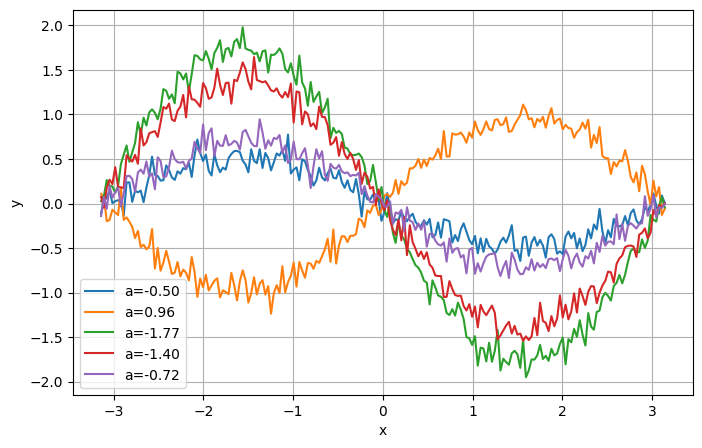

In [13]:
#| echo: false
x = np.linspace(-np.pi, np.pi, 200)
plt.figure(figsize=(8, 5))

for i in range(5):
    a = np.random.uniform(-2, 2)
    y = sine(x, a) + np.random.normal(0, 0.1,size=x.shape)
    plt.plot(x, y, label=f"a={a:.2f}")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### The Model

A CNP has two main components:

1. Encoder : A neural network that takes in context pair $(x_i , y_i)$ and transforms them into representation vector $r_i$. To combine information from all context points, we take an average over all points and get a vector $r$ of same dimension as each vector $r_i$.
2. Decoder: A neural network that uses the representation $r$ to make predictions at target point $x_t$. We pass in concatenated $[r,x_t]$ as the input and the output is the predicted mean and variance of $y_t$. We normalize the value of sigma to make sure it is positive.

In [53]:
class Encoder(nn.Module):
  def __init__(self, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(2, 128) # (x_context, y_context) as input
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class Decoder(nn.Module):
  def __init__(self,r_dim):
    super().__init__()
    self.fc1 = nn.Linear(r_dim+1, 128) # (r vector, x_target) concatenated as input
    self.fc2 = nn.Linear(128, 2)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    mu,log_sigma = x.chunk(2, dim=-1)
    return mu, log_sigma

class ConditionalNeuralProcess(nn.Module):
  def __init__(self,r_dim):
    super().__init__()
    self.encoder = Encoder(r_dim)
    self.decoder = Decoder(r_dim)

  def forward(self,context_x,context_y,target_x):

    context_point = torch.cat([context_x, context_y], dim=-1)
    r_i = self.encoder(context_point)
    r =torch.mean(r_i,dim=0)
    num_target = target_x.shape[0]
    r_expanded = r.expand(num_target, -1)
    decoder_input = torch.cat([r_expanded, target_x], dim=-1)

    mu, log_sigma = self.decoder(decoder_input)
    sigma = torch.exp(log_sigma) # variance must be positive

    return mu, sigma

r_dim = 128
model = ConditionalNeuralProcess(r_dim).to(device)


The code below will help us visualize the model inputs and predictions.

In [54]:
def visualize_cnp_predictions(model, context_x, context_y, target_x, target_y):
    model.eval()

    with torch.no_grad():
        # Generate a dense range of x-values to plot the learned function smoothly
        x_plot = torch.linspace(-np.pi, np.pi, 500, device=device).unsqueeze(-1)


        mu_pred, sigma_pred = model(context_x, context_y, x_plot)

        context_x_np = context_x.cpu().numpy()
        context_y_np = context_y.cpu().numpy()
        target_x_np = target_x.cpu().numpy()
        target_y_np = target_y.cpu().numpy()
        x_plot_np = x_plot.cpu().numpy()
        mu_pred_np = mu_pred.cpu().numpy()
        sigma_pred_np = sigma_pred.cpu().numpy()

    plt.figure(figsize=(10, 6))

    plt.scatter(context_x_np, context_y_np, c='red', label='Context Points', marker='o', s=70)
    plt.scatter(target_x_np, target_y_np, c='blue', label='True Target Points', marker='x', s=70)

    plt.plot(x_plot_np, mu_pred_np, color='green', linewidth=2, label='Predicted Mean')
    plt.fill_between(
        x_plot_np.squeeze(),
        (mu_pred_np - 2 * sigma_pred_np).squeeze(),
        (mu_pred_np + 2 * sigma_pred_np).squeeze(),
        color='green', alpha=0.2, label='Variance'
    )

    plt.title('Conditional Neural Process Predictions')
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


Lets sample data for an example function with a = 1.5 , What does our model's prediction look like before training?

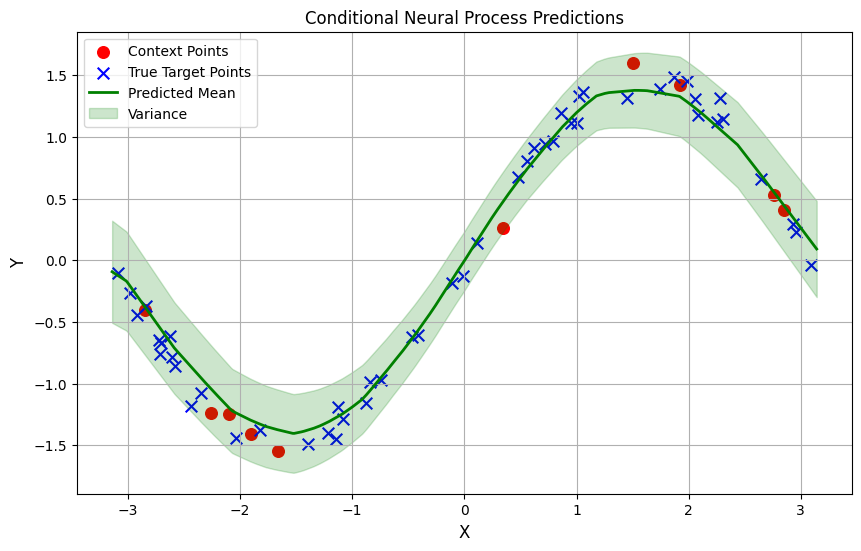

In [81]:
#| echo: false
x_context_example, y_context_example, x_target_example, y_target_example = create_training_data(sine,a=1.5,num_points=60,num_context=10)
visualize_cnp_predictions(model,x_context_example,y_context_example,x_target_example,y_target_example)

### Training

The model is trained by minimizing the negative log-likelihood (NLL) — encouraging the predicted distributions to assign high probability to the true target values.

In [82]:
r_dim = 128
model = ConditionalNeuralProcess(r_dim).to(device)

def NLL(mu_pred, sigma_pred, target_y):
    dist = Normal(mu_pred, sigma_pred)
    log_prob = dist.log_prob(target_y)
    loss = -torch.mean(log_prob)

    return loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10000
losses=[]
predictions_example=[]
x_plot_example = torch.linspace(-np.pi, np.pi, 500, device=device).unsqueeze(-1)

for epoch in range(num_epochs):
    x_context, y_context, x_target, y_target = create_training_data(sine)
    optimizer.zero_grad()
    mu_pred, sigma_pred = model(x_context, y_context, x_target)
    loss = NLL(mu_pred, sigma_pred, y_target)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
      #visualize_cnp_predictions(model,x_context_example,y_context_example,x_target_example,y_target_example)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    with torch.no_grad():
        mu, sigma = model(x_context_example, y_context_example, x_plot_example)
        predictions_example.append((mu.cpu().numpy(), sigma.cpu().numpy()))


Epoch 1000/10000, Loss: 0.47015589475631714
Epoch 2000/10000, Loss: -0.42924317717552185
Epoch 3000/10000, Loss: -0.12417580932378769
Epoch 4000/10000, Loss: -0.6538487076759338
Epoch 5000/10000, Loss: -0.4501391053199768
Epoch 6000/10000, Loss: -0.36041417717933655
Epoch 7000/10000, Loss: -0.09112993627786636
Epoch 8000/10000, Loss: -0.6509308218955994
Epoch 9000/10000, Loss: -0.7228361368179321
Epoch 10000/10000, Loss: -0.17287860810756683


The losses for the overall training process oscillate a lot but we can see a downward trend, as in the plot below.

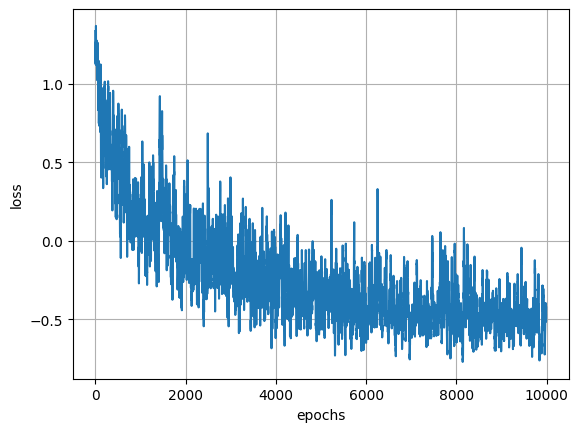

In [83]:
#| echo: false
window = 10
smooth_losses = np.convolve(losses, np.ones(window)/window, mode="valid")
plt.plot(smooth_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()

We can visualize how the training makes our model converge to the example function using a short animation. Observe how the shaded green area indicating variance becomes smaller as our model becomes more accurate and confident.

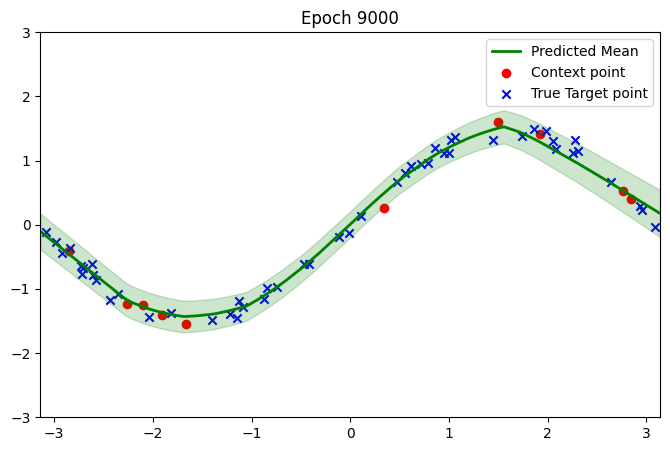

In [84]:
#| include: false
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot([], [], 'g-', lw=2, label="Predicted Mean")
fill = None

ax.scatter(x_context_example.cpu(), y_context_example.cpu(),
           c='red', label="Context point")
ax.scatter(x_target_example.cpu(), y_target_example.cpu(),
           c='blue', marker='x', label="True Target point")
x_plot_example = np.linspace(-np.pi, np.pi, 500).reshape(-1, 1)

ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-3, 3)
ax.legend()

def init():
    return line,

def update(frame):
    global fill
    if fill: fill.remove()

    mu, sigma = predictions_example[frame]
    line.set_data(x_plot_example, mu)
    fill = ax.fill_between(
        x_plot_example.squeeze(),
        (mu - 2 * sigma).squeeze(),
        (mu + 2 * sigma).squeeze(),
        color='green', alpha=0.2
    )
    ax.set_title(f"Epoch {frame}")
    return line, fill

ani = animation.FuncAnimation(
    fig, update, range(0, len(predictions_example), 1000),
    init_func=init, blit=False, interval=200
)

ani.save("cnp_training.gif", writer="pillow", dpi=80)


![](cnp_training.gif){fig-align="center"}

### Conclusion

So, after training, the model is predicting a good approximation of our function.

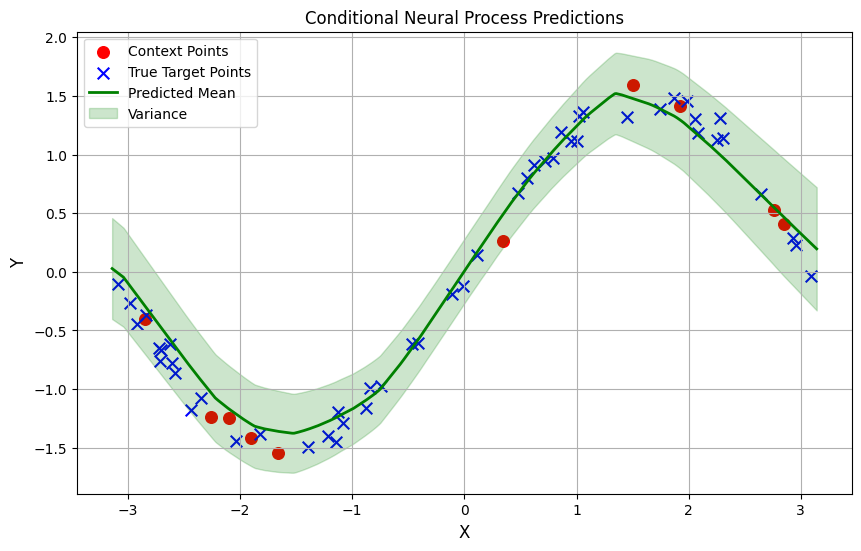

In [85]:
#| echo: false
visualize_cnp_predictions(model,x_context_example,y_context_example,x_target_example,y_target_example)

I would say that CNPs are a rather simple approximation to neural processes. Their aggregator function being simply a mean may lose information and they do not model uncertainty as well, being a deterministic model. However they are simple to train and perform reasonably well on simple functions such as the sine wave.

### Active Learning Loop

The CNP trained above can help us in choosing the next points to acquire in order to make even better predictions about a particular sine wave. Below is the code for two acquisitions strategies - a random strategy and an uncertainty based strategy which chooses point with maximum variance.

In [46]:
def random_acquisition(x_context, y_context, x_target, y_target):
    idx = np.random.randint(len(x_target))

    x = x_target[idx:idx+1]
    y = y_target[idx:idx+1]

    x_context_new = torch.cat([x_context, x], dim=0)
    y_context_new = torch.cat([y_context, y], dim=0)

    x_target_new = torch.cat([x_target[:idx], x_target[idx+1:]], dim=0)
    y_target_new = torch.cat([y_target[:idx], y_target[idx+1:]], dim=0)

    return  x_context_new, y_context_new, x_target_new, y_target_new

def uncertainty_acquisition(sigma, x_context, y_context, x_target, y_target):
    idx = torch.argmax(sigma).item()

    x = x_target[idx:idx+1]
    y = y_target[idx:idx+1]

    x_context_new = torch.cat([x_context, x], dim=0)
    y_context_new = torch.cat([y_context, y], dim=0)

    x_target_new = torch.cat([x_target[:idx], x_target[idx+1:]], dim=0)
    y_target_new = torch.cat([y_target[:idx], y_target[idx+1:]], dim=0)

    return  x_context_new, y_context_new, x_target_new, y_target_new


Lets try this on the example function above with a=1.5
We start with 2 context points and make one target point become context point per epoch.

In [86]:
num_epochs = 50
a=1.5
x_context, y_context, x_target, y_target = create_training_data(sine, a,num_points=100, num_context=2)

def rmse_loss(y_pred,y_target):
  return torch.sqrt(torch.mean((y_pred - y_target) ** 2)).item()

In [87]:
import copy

model_random = copy.deepcopy(model)
model_uncertainty = copy.deepcopy(model)

opt_random = torch.optim.Adam(model_random.parameters(), lr=1e-3)
opt_uncertainty = torch.optim.Adam(model_uncertainty.parameters(), lr=1e-3)

x_context_r, y_context_r = x_context.clone(), y_context.clone()
x_target_r, y_target_r = x_target.clone(), y_target.clone()

x_context_u, y_context_u = x_context.clone(), y_context.clone()
x_target_u, y_target_u = x_target.clone(), y_target.clone()


In [ ]:
#| include: false

import imageio.v2 as imageio
import os

def visualize_comparison_frame(model_r, model_u,
                               context_x_r, context_y_r, target_x_r, target_y_r,
                               context_x_u, context_y_u, target_x_u, target_y_u,
                               epoch, save_dir="frames"):
    os.makedirs(save_dir, exist_ok=True)

    x_plot = torch.linspace(-np.pi, np.pi, 500, device=context_x_r.device).unsqueeze(-1)

    with torch.no_grad():
        mu_r, sigma_r = model_r(context_x_r, context_y_r, x_plot)
        mu_u, sigma_u = model_u(context_x_u, context_y_u, x_plot)

    def to_np(t): return t.detach().cpu().numpy()
    x_plot_np = to_np(x_plot)

    mu_r, sigma_r = to_np(mu_r), to_np(sigma_r)
    mu_u, sigma_u = to_np(mu_u), to_np(sigma_u)

    cxr, cyr = to_np(context_x_r), to_np(context_y_r)
    txr, tyr = to_np(target_x_r), to_np(target_y_r)

    cxu, cyu = to_np(context_x_u), to_np(context_y_u)
    txu, tyu = to_np(target_x_u), to_np(target_y_u)

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Random
    ax1.scatter(cxr, cyr, c='red', label='Context', marker='o', s=60)
    ax1.scatter(txr, tyr, c='blue', label='Target', marker='x', s=60)
    ax1.plot(x_plot_np, mu_r, color='green', lw=2, label='Pred Mean')
    ax1.fill_between(x_plot_np.squeeze(),
                     (mu_r - 2 * sigma_r).squeeze(),
                     (mu_r + 2 * sigma_r).squeeze(),
                     color='green', alpha=0.2)
    ax1.set_title("Random Acquisition")
    ax1.set_xlim(-np.pi, np.pi)
    ax1.set_ylim(-3, 3)
    ax1.legend()

    # Uncertainty
    ax2.scatter(cxu, cyu, c='red', label='Context', marker='o', s=60)
    ax2.scatter(txu, tyu, c='blue', label='Target', marker='x', s=60)
    ax2.plot(x_plot_np, mu_u, color='green', lw=2, label='Pred Mean')
    ax2.fill_between(x_plot_np.squeeze(),
                     (mu_u - 2 * sigma_u).squeeze(),
                     (mu_u + 2 * sigma_u).squeeze(),
                     color='green', alpha=0.2)
    ax2.set_title("Uncertainty Acquisition")
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_ylim(-3, 3)
    ax2.legend()

    fig.suptitle(f"CNP Active Learning – Epoch {epoch}", fontsize=14)
    plt.tight_layout()

    frame_path = os.path.join(save_dir, f"frame_{epoch:04d}.png")
    plt.savefig(frame_path)
    plt.close()
    return frame_path


def make_gif_from_frames(frame_dir="frames", gif_name="comparison.gif", fps=5):
    files = sorted([os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".png")])
    images = [imageio.imread(f) for f in files]
    imageio.mimsave(gif_name, images, fps=fps, loop=0)
    print(f"GIF saved to {gif_name}")


In [89]:
losses_r, rmses_r = [], []
losses_u, rmses_u = [], []
frame_paths = []
predictions_r, predictions_u = [], []
for epoch in range(num_epochs):
    if len(x_target_r) == 0 or len(x_target_u) == 0:
        print("No more target points left to acquire.")
        break

    # Random acquisition
    opt_random.zero_grad()
    mu_r, sigma_r = model_random(x_context_r, y_context_r, x_target_r)
    loss_r = NLL(mu_r, sigma_r, y_target_r)
    loss_r.backward()
    opt_random.step()

    rmse_r = torch.sqrt(torch.mean((mu_r - y_target_r) ** 2)).item()
    losses_r.append(loss_r.item())
    rmses_r.append(rmse_r)

    x_context_r, y_context_r, x_target_r, y_target_r = random_acquisition(
        x_context_r, y_context_r, x_target_r, y_target_r
    )

    # Uncertainty acquisition
    opt_uncertainty.zero_grad()
    mu_u, sigma_u = model_uncertainty(x_context_u, y_context_u, x_target_u)
    loss_u = NLL(mu_u, sigma_u, y_target_u)
    loss_u.backward()
    opt_uncertainty.step()

    rmse_u = torch.sqrt(torch.mean((mu_u - y_target_u) ** 2)).item()
    losses_u.append(loss_u.item())
    rmses_u.append(rmse_u)

    x_context_u, y_context_u, x_target_u, y_target_u = uncertainty_acquisition(
        sigma_u, x_context_u, y_context_u, x_target_u, y_target_u
    )

    with torch.no_grad():
      x_plot = torch.linspace(-np.pi, np.pi, 500).unsqueeze(-1).to(device)
      mu_r, sigma_r = model_random(x_context_r, y_context_r, x_plot)
      mu_u, sigma_u = model_uncertainty(x_context_u, y_context_u, x_plot)

      predictions_r.append((mu_r.cpu().numpy(), sigma_r.cpu().numpy()))
      predictions_u.append((mu_u.cpu().numpy(), sigma_u.cpu().numpy()))


    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  Random:     NLL={loss_r.item():.4f}, RMSE={rmse_r:.4f}")
        print(f"  Uncertainty: NLL={loss_u.item():.4f}, RMSE={rmse_u:.4f}")

    if epoch % 5 == 0:
          frame = visualize_comparison_frame(model_random, model_uncertainty,
                                            x_context_r, y_context_r, x_target_r, y_target_r,
                                            x_context_u, y_context_u, x_target_u, y_target_u,
                                            epoch)
          frame_paths.append(frame)


Epoch 0/50
  Random:     NLL=-0.2657, RMSE=0.1938
  Uncertainty: NLL=-0.2657, RMSE=0.1938
Epoch 10/50
  Random:     NLL=-0.7815, RMSE=0.1068
  Uncertainty: NLL=-0.7625, RMSE=0.1060
Epoch 20/50
  Random:     NLL=-0.8836, RMSE=0.0985
  Uncertainty: NLL=-0.8110, RMSE=0.1106
Epoch 30/50
  Random:     NLL=-0.8785, RMSE=0.1029
  Uncertainty: NLL=-0.9843, RMSE=0.0924
Epoch 40/50
  Random:     NLL=-0.8947, RMSE=0.1020
  Uncertainty: NLL=-1.0516, RMSE=0.0880


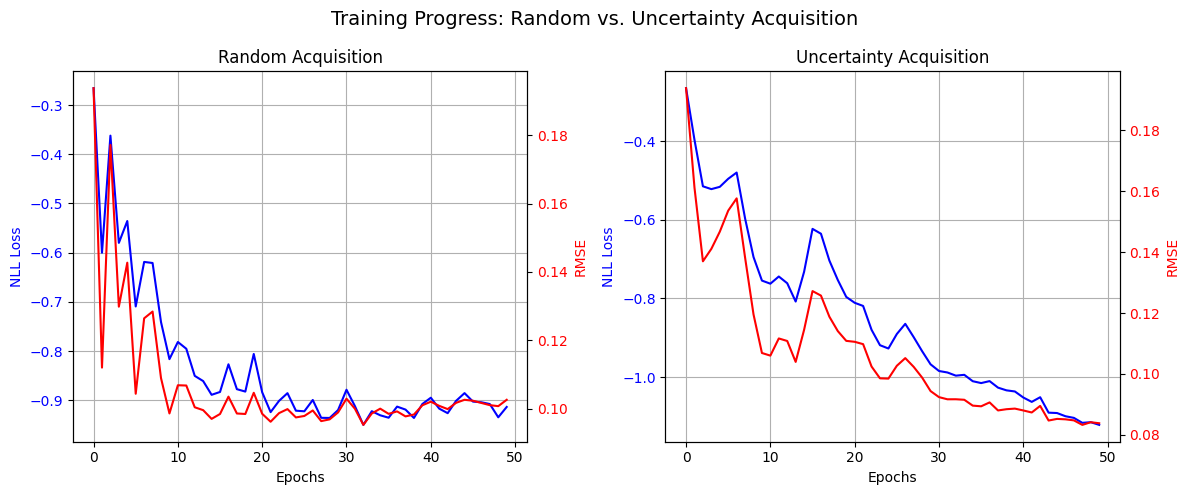

In [90]:
#| echo: false

epochs_r = range(len(losses_r))
epochs_u = range(len(losses_u))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# --- Random Acquisition ---
ax1.plot(epochs_r, losses_r, 'b-', label='NLL Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('NLL Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax1b = ax1.twinx()
ax1b.plot(epochs_r, rmses_r, 'r-', label='RMSE')
ax1b.set_ylabel('RMSE', color='r')
ax1b.tick_params(axis='y', labelcolor='r')

ax1.set_title("Random Acquisition")

# --- Uncertainty Acquisition ---
ax2.plot(epochs_u, losses_u, 'b-', label='NLL Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('NLL Loss', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.grid(True)

ax2b = ax2.twinx()
ax2b.plot(epochs_u, rmses_u, 'r-', label='RMSE')
ax2b.set_ylabel('RMSE', color='r')
ax2b.tick_params(axis='y', labelcolor='r')

ax2.set_title("Uncertainty Acquisition")

plt.suptitle("Training Progress: Random vs. Uncertainty Acquisition", fontsize=14)
plt.tight_layout()
plt.show()


In [91]:
#| include: false

make_gif_from_frames("frames", "comparison.gif", fps=2)

GIF saved to comparison.gif


![Random vs Uncertainty Acquisition](comparison.gif)

In [ ]:
#| include: false
# trained_model = model
# losses=[]
# rmses=[]
# x_context2, y_context2, x_target2, y_target2 = x_context, y_context, x_target, y_target

# for epoch in range(num_epochs):
#     if len(x_target) == 0:
#         print("No more target points left to acquire.")
#         break
#     optimizer.zero_grad()
#     mu_pred, sigma_pred = trained_model(x_context2, y_context2, x_target2)
#     loss = NLL(mu_pred, sigma_pred, y_target2)
#     losses.append(loss.item())
#     loss.backward()
#     optimizer.step()

#     rmse = rmse_loss(mu_pred,y_target2)
#     rmses.append(rmse)

#     if (epoch) % 10 == 0:
#       visualize_cnp_predictions(trained_model,x_context2,y_context2,x_target2,y_target2)
#       print(f"Epoch {epoch}/{num_epochs}, NLL Loss: {loss.item()}, RMSE Loss: {rmse}")

#     x_context2, y_context2, x_target2, y_target2 = uncertainty_acquisition(sigma_pred,x_context2, y_context2, x_target2, y_target2)


In [ ]:
#| include: false

# trained_model = model
# losses=[]
# rmses=[]
# x_context1, y_context1, x_target1, y_target1 = x_context, y_context, x_target, y_target

# for epoch in range(num_epochs):
#     if len(x_target) == 0:
#         print("No more target points left to acquire.")
#         break
#     optimizer.zero_grad()
#     mu_pred, sigma_pred = trained_model(x_context1, y_context1, x_target1)
#     loss = NLL(mu_pred, sigma_pred, y_target1)
#     losses.append(loss.item())
#     loss.backward()
#     optimizer.step()

#     rmse = rmse_loss(mu_pred,y_target1)
#     rmses.append(rmse)

#     if (epoch) % 10 == 0:
#       visualize_cnp_predictions(trained_model,x_context1,y_context1,x_target1,y_target1)
#       print(f"Epoch {epoch}/{num_epochs}, NLL Loss: {loss.item()}, RMSE Loss: {rmse}")

#     x_context1, y_context1, x_target1, y_target1 = random_acquisition(x_context1, y_context1, x_target1, y_target1)


Both strategies reduce the loss of the model. The uncertainty based method acquires more points from the peripheries — that is, when $x$ is close to $\pi$ or $-\pi$ whereas random method samples uniformly.



Credits to [Kaspar Martens](https://kasparmartens.rbind.io/post/np/) and [Deepmind](https://colab.research.google.com/github/deepmind/neural-processes/blob/master/conditional_neural_process.ipynb#scrollTo=P3LJYP1Qh-jO)  for an excellent tutorial on this topic.